# Hybrid Recommendation System (Advanced)

## Goal
Combine **ML predictions** with **content-based scoring**, **user preferences**, and **review quality** to create a hybrid recommendation system with **advanced filtering**.

## What's New vs. Basic Content-Based?
This notebook includes ALL advanced features from model_development.ipynb:

**🔒 Hard Filters** (auto-exclude BEFORE scoring):
- NSFW content filter
- Early Access filter  
- Meta genre/tag filtering (Indie, Casual, Utilities, etc.)
- Minimum review thresholds
- User-specified hard exclusions (applied AFTER scoring)

**🎯 Smart Scoring** (4 separate components):
1. **ML Prediction (35%)**: Learned patterns from YOUR playtime behavior
   - Trained on tags, genres, interaction features
   - NO review bias (reviews excluded from training)
   
2. **Content-Based (35%)**: Similarity to your loved games
   - Tag matching (55%) - specific gameplay features
   - Genre matching (25%) - broad categories
   - Median playtime (20%) - engagement signal
   - NO reviews in content score!
   
3. **Preference Adjustments (20%)**: Your explicit preferences, eventually a user should be able to set these manually via UI but also have option to auto-learn from <5hr games and liked games
   - Boosts for preferred genres/tags (+5 to +20 points)
   - Penalties for disliked genres/tags (from <5hr games)
   - Soft signals that influence ranking
   
4. **Review Quality (10%)**: Community sentiment
   - Tiered quality multipliers (95%+ = 2.5x, <60% = 0.1x)
   - Volume bonus (logarithmic)
   - Counted ONCE (not in content or ML)

## Approach
1. Apply universal filters (NSFW, Early Access, min reviews)
2. Load trained ML model predictions (NO review bias)
3. Calculate content-based scores (tags + genres + playtime)
4. Calculate preference adjustments (boosts + disliked penalties) [user controlled eventually or auto-learned]
5. Calculate review quality score separately
6. Combine with proper weights: **35% ML + 35% Content + 20% Prefs + 10% Reviews**
7. Apply hard exclusions (user-specified never-show filters)
8. Return top 20

## Scoring Formula
```
Content Score (0-100) = 
  + 55% Tag Matching (weighted by playtime, excludes NSFW/meta)
  + 25% Genre Matching (excludes meta genres)
  + 20% Median Playtime (engagement signal)
  
Preference Score (0-100) =
  + Boosts for preferred genres/tags
  - Penalties for disliked genres/tags (from <5hr games)
  
Review Score (0-100) =
  + Quality tier (60-95%+ positive)
  + Volume bonus (log scale)
  
Final Score = 0.35*ML + 0.35*Content + 0.20*Prefs + 0.10*Reviews
```

**Architecture**: Universal Filters → ML/Content/Prefs/Review → Combine → Hard Exclusions

In [1]:
import pandas as pd
import numpy as np
import ast
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Data

Load all necessary datasets:
- User's owned games (with engagement scores)
- Steam catalog (candidates for recommendations)
- Trained ML model and scaler
- ML recommendations (from feature_engineering.ipynb)

In [2]:
# Load datasets
owned_games = pd.read_csv('../data/owned_games_enriched.csv')
steam_catalog = pd.read_csv('../data/steam_catalog_detailed.csv')
ml_recommendations_v2 = pd.read_csv('../data/ml_recommendations_v2_diverse.csv')

print(f"Owned games: {len(owned_games)}")
print(f"Steam catalog: {len(steam_catalog)}")
print(f"ML recommendations loaded: {len(ml_recommendations_v2)}")

# Identify owned game IDs
owned_appids = set(owned_games['appid'].values)
catalog_unowned = steam_catalog[~steam_catalog['appid'].isin(owned_appids)].copy()

print(f"\nCatalog games you don't own: {len(catalog_unowned)}")

Owned games: 67
Steam catalog: 86542
ML recommendations loaded: 20

Catalog games you don't own: 86483


## 3. Load/Prepare ML Predictions

We already have ML predictions from feature_engineering.ipynb.  
Let's normalize them to 0-100 scale for consistency with content-based scoring.

In [3]:
# ML recommendations already have 'predicted_engagement_v2' column (0-100 scale)
# Let's verify the range
print("ML Prediction Statistics:")
print(ml_recommendations_v2['predicted_engagement_v2'].describe())

# Normalize to 0-100 if needed (should already be in this range)
ml_scores = ml_recommendations_v2[['appid', 'name', 'predicted_engagement_v2']].copy()
ml_scores.rename(columns={'predicted_engagement_v2': 'ml_score'}, inplace=True)

print(f"\nML scores prepared for {len(ml_scores)} games")

ML Prediction Statistics:
count    20.000000
mean     80.548634
std       2.082195
min      78.426340
25%      78.945870
50%      79.884896
75%      81.461362
max      86.496213
Name: predicted_engagement_v2, dtype: float64

ML scores prepared for 20 games


## 4. Build Content-Based Scoring System

Implement content-based filtering using:
1. **Tag similarity** to user's loved games (55%)
2. **Genre overlap** (25%)
3. **Median playtime similarity** (20%)

In [4]:
def parse_tags(tag_string):
    """Parse tag string into dictionary"""
    if pd.isna(tag_string):
        return {}
    try:
        return ast.literal_eval(str(tag_string))
    except:
        return {}

def parse_genre(genre_string):
    """Parse genre string into list"""
    if pd.isna(genre_string):
        return []
    return [g.strip() for g in str(genre_string).split(',')]

# Parse tags and genres for both datasets
owned_games['tags_dict'] = owned_games['tags'].apply(parse_tags)
owned_games['genre_list'] = owned_games['genre'].apply(parse_genre)

catalog_unowned['tags_dict'] = catalog_unowned['tags'].apply(parse_tags)
catalog_unowned['genre_list'] = catalog_unowned['genre'].apply(parse_genre)

print("Tags and genres parsed for content-based scoring")

Tags and genres parsed for content-based scoring


In [5]:
# Build user profile from loved games (50+ hours) AND identify disliked games
loved_games = owned_games[owned_games['playtime_forever'] > 3000].copy()  # 50+ hours

# Also identify disliked games (games owned but barely/never played)
disliked_games = owned_games[owned_games['playtime_forever'] < 300].copy()  # <5 hours

print(f"Your loved games (50+ hours): {len(loved_games)}")
print(f"Your disliked games (<5 hours): {len(disliked_games)}")

print(f"\n\nTop 10 loved games:")
for _, game in loved_games.nlargest(10, 'playtime_forever')[['name', 'playtime_forever']].iterrows():
    print(f"  - {game['name']}: {game['playtime_forever']/60:.1f} hours")

Your loved games (50+ hours): 9
Your disliked games (<5 hours): 33


Top 10 loved games:
  - Cyberpunk 2077: 1031.4 hours
  - HELLDIVERS 2: 226.4 hours
  - Red Dead Redemption 2: 173.7 hours
  - Valheim: 129.2 hours
  - Fallout 4: 117.0 hours
  - The Last of Us Part I: 105.0 hours
  - Prey: 73.5 hours
  - Lossless Scaling: 66.3 hours
  - Balatro: 53.3 hours


In [6]:
# Create user tag profile (weighted by playtime)
# Also build disliked profile from games with low playtime
user_tag_profile = {}
total_playtime = loved_games['playtime_forever'].sum()

# NSFW and meta tag filters (same as model_development)
nsfw_tags = {
    'Sexual Content', 'Nudity', 'NSFW', 'Adult',
    'Hentai', 'Erotic', 'Sexual', 'Porn', '18+', 'Adult Only'
}

meta_tags = {
    'Indie', 'Casual', 'Free to Play', 'Early Access',
    'Great Soundtrack', 'Singleplayer', 'Multiplayer',
    'Co-op', 'Online Co-Op', 'PvP', 'PvE',
    'Moddable', 'Controller', 'Partial Controller Support',
    'Steam Achievements', 'Steam Cloud', 'Steam Trading Cards',
    'VR', 'VR Only',
    'Anime', 'Cute', 'Funny', 'Comedy',
    'Classic', 'Remake', 'Remaster', 'Retro'
}

# Build loved tag profile
for _, game in loved_games.iterrows():
    playtime_weight = game['playtime_forever'] / total_playtime
    for tag, votes in game['tags_dict'].items():
        # Skip NSFW and meta tags
        if tag in nsfw_tags or tag in meta_tags:
            continue
        if tag not in user_tag_profile:
            user_tag_profile[tag] = 0
        user_tag_profile[tag] += votes * playtime_weight

# Build disliked tag profile (tags that appear in low-playtime games)
disliked_tag_profile = {}
for _, game in disliked_games.iterrows():
    for tag in game['tags_dict'].keys():
        # Skip NSFW and meta tags
        if tag in nsfw_tags or tag in meta_tags:
            continue
        disliked_tag_profile[tag] = disliked_tag_profile.get(tag, 0) + 1

# Remove overlaps with loved tags (don't penalize tags you also love)
loved_tag_set = set(user_tag_profile.keys())
disliked_tag_profile = {tag: count for tag, count in disliked_tag_profile.items() 
                       if tag not in loved_tag_set and count >= 3}  # At least 3 games to be confident

# Sort by importance
top_user_tags = sorted(user_tag_profile.items(), key=lambda x: x[1], reverse=True)[:30]

print("\n\nYour top 30 tags (weighted by playtime, excluding NSFW/meta):")
for tag, score in top_user_tags:
    print(f"  {tag}: {score:.1f}")

if disliked_tag_profile:
    print(f"\n\nDisliked tags (appear in unplayed games, NOT in loved games):")
    for tag, count in sorted(disliked_tag_profile.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  - {tag}: {count} games (will be penalized)")



Your top 30 tags (weighted by playtime, excluding NSFW/meta):
  Open World: 4271.3
  Cyberpunk: 3458.4
  RPG: 3015.1
  Story Rich: 2972.6
  Sci-fi: 2745.2
  FPS: 2717.5
  Atmospheric: 2569.5
  First-Person: 2562.7
  Mature: 2519.2
  Exploration: 2507.8
  Futuristic: 2391.2
  Action: 2301.8
  Adventure: 1838.3
  Violent: 1486.6
  Action RPG: 1459.7
  Character Customization: 1128.0
  Immersive Sim: 650.9
  Shooter: 571.2
  Post-apocalyptic: 548.4
  Third Person: 457.1
  Third-Person Shooter: 398.9
  Sandbox: 365.4
  Survival: 351.7
  Western: 239.8
  Realistic: 199.9
  Gore: 155.8
  Open World Survival Craft: 155.5
  Horses: 144.4
  Beautiful: 143.0
  Difficult: 131.7


Disliked tags (appear in unplayed games, NOT in loved games):
  - Dark: 6 games (will be penalized)
  - Dystopian : 5 games (will be penalized)
  - Competitive: 4 games (will be penalized)
  - Physics: 3 games (will be penalized)
  - Puzzle: 3 games (will be penalized)
  - Arena Shooter: 3 games (will be penalized)
  -

In [7]:
# Create user genre profile
# Also build disliked genre profile
user_genre_profile = {}
disliked_genre_profile = {}

# Meta genres to exclude from matching
meta_genres = {
    'Indie', 'Casual', 'Early Access', 'Free to Play',
    'Massively Multiplayer',
    'Utilities', 'Software', 'Animation & Modeling', 'Design & Illustration',
    'Audio Production', 'Video Production', 'Web Publishing', 'Education',
    'Photo Editing', 'Game Development'
}

for _, game in loved_games.iterrows():
    playtime_weight = game['playtime_forever'] / total_playtime
    for genre in game['genre_list']:
        # Skip meta genres
        if genre in meta_genres:
            continue
        if genre not in user_genre_profile:
            user_genre_profile[genre] = 0
        user_genre_profile[genre] += playtime_weight

# Build disliked genre profile
for _, game in disliked_games.iterrows():
    for genre in game['genre_list']:
        # Skip meta genres
        if genre in meta_genres:
            continue
        disliked_genre_profile[genre] = disliked_genre_profile.get(genre, 0) + 1

# Remove overlaps
loved_genre_set = set(user_genre_profile.keys())
disliked_genre_profile = {genre: count for genre, count in disliked_genre_profile.items() 
                         if genre not in loved_genre_set and count >= 3}

print("\n\nYour genre preferences (excluding meta genres):")
for genre, score in sorted(user_genre_profile.items(), key=lambda x: x[1], reverse=True):
    print(f"  {genre}: {score:.2%}")

if disliked_genre_profile:
    print(f"\n\nDisliked genres (will be penalized):")
    for genre, count in sorted(disliked_genre_profile.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {genre}: {count} games")



Your genre preferences (excluding meta genres):
  RPG: 64.66%
  Action: 35.82%
  Adventure: 24.36%
  Strategy: 2.70%


Disliked genres (will be penalized):
  - Free To Play: 3 games


In [9]:
# Calculate content-based scores for catalog games (FIXED - NO REVIEW BIAS)
def calculate_content_score(game_row, user_tag_profile, user_genre_profile, loved_games):
    """
    Calculate content-based score (0-100) for a single game
    
    Components (NO REVIEWS - they're separate!):
    - Tag similarity: 55 points (MOST IMPORTANT - specific gameplay features)
    - Genre overlap: 25 points (broad categories)
    - Median playtime match: 20 points (engagement signal)
    
    ⚠️ Reviews are NOT included here - they're a separate 10% component
    """
    score = 0
    
    # NSFW filter - these tags auto-disqualify
    nsfw_tags = {
        'Sexual Content', 'Nudity', 'NSFW', 'Adult',
        'Hentai', 'Erotic', 'Sexual', 'Porn', '18+', 'Adult Only'
    }
    
    meta_tags = {
        'Indie', 'Casual', 'Free to Play', 'Early Access',
        'Great Soundtrack', 'Singleplayer', 'Multiplayer',
        'Co-op', 'Online Co-Op', 'PvP', 'PvE',
        'Moddable', 'Controller', 'Partial Controller Support',
        'Steam Achievements', 'Steam Cloud', 'Steam Trading Cards',
        'VR', 'VR Only',
        'Anime', 'Cute', 'Funny', 'Comedy',
        'Classic', 'Remake', 'Remaster', 'Retro'
    }
    
    meta_genres = {
        'Indie', 'Casual', 'Early Access', 'Free to Play',
        'Massively Multiplayer',
        'Utilities', 'Software', 'Animation & Modeling', 'Design & Illustration',
        'Audio Production', 'Video Production', 'Web Publishing', 'Education',
        'Photo Editing', 'Game Development'
    }
    
    # Get game tags and handle both dict and list formats
    game_tags_raw = game_row['tags_dict']
    
    # Convert to dict if it's a list or other format
    if isinstance(game_tags_raw, dict):
        game_tags = game_tags_raw
    elif isinstance(game_tags_raw, list):
        # If it's a list, convert to dict with default votes of 1
        game_tags = {tag: 1 for tag in game_tags_raw}
    else:
        game_tags = {}
    
    # Check for NSFW content (hard filter - return 0 if found)
    if any(tag in nsfw_tags for tag in game_tags.keys()):
        return 0  # NSFW content auto-disqualified
    
    # 1. Tag similarity (55 points) - INCREASED from 45% since reviews removed
    tag_score = 0
    if game_tags:
        for tag, votes in game_tags.items():
            # Skip NSFW and meta tags from scoring
            if tag in nsfw_tags or tag in meta_tags:
                continue
            
            # Positive matches
            if tag in user_tag_profile:
                tag_score += user_tag_profile[tag] * (votes / 1000)  # Normalize votes
        
        # Normalize tag score to 0-55 range
        max_possible_tag_score = sum(user_tag_profile.values()) * 10  # Approximate max
        tag_score = min(55, (tag_score / max_possible_tag_score) * 55) if max_possible_tag_score > 0 else 0
    
    score += tag_score
    
    # 2. Genre overlap (25 points) - INCREASED from 20% since reviews removed
    genre_score = 0
    game_genres = game_row['genre_list']
    if game_genres:
        for genre in game_genres:
            # Skip meta genres
            if genre in meta_genres:
                continue
            
            # Positive matches
            if genre in user_genre_profile:
                genre_score += user_genre_profile[genre]
        
        genre_score = min(25, genre_score * 25)  # Normalize to 0-25
    
    score += genre_score
    
    # 3. Median playtime similarity (20 points) - UNCHANGED
    # Higher median = deeper, more engaging game
    median_playtime = game_row.get('median_forever', 0)
    if pd.notna(median_playtime) and median_playtime > 0:
        median_hours = median_playtime / 60
        # Games with high median playtime get higher scores
        if median_hours >= 50:
            playtime_score = 20  # Deep, engaging game
        elif median_hours >= 20:
            playtime_score = 15  # Good engagement
        elif median_hours >= 10:
            playtime_score = 10  # Decent engagement
        elif median_hours >= 5:
            playtime_score = 5   # Some engagement
        else:
            playtime_score = 0   # Low engagement
    else:
        playtime_score = 0
    score += playtime_score
    
    # ⚠️ REVIEWS REMOVED - they're now a separate 10% component!
    # NO review quality scoring here
    
    # Ensure score doesn't go below 0
    return max(0, score)

print("Calculating content-based scores for catalog games...")
print("This may take a minute...")
print("\n✅ FIXED: Reviews removed from Content Score")
print("Features:")
print("  ✅ Tag matching (55%) - specific gameplay features")
print("  ✅ Genre matching (25%) - broad categories")
print("  ✅ Median playtime (20%) - engagement signal")
print("  ❌ Reviews (0%) - moved to separate component")
print("  ✅ NSFW filter (hard exclusion)")
print("  ✅ Meta tag/genre filtering (excluded from matching)")

catalog_unowned['content_score'] = catalog_unowned.apply(
    lambda row: calculate_content_score(
        row, user_tag_profile, user_genre_profile, loved_games
    ),
    axis=1
)

print(f"\n✓ Content-based scores calculated!")
print(f"\nContent Score Statistics:")
print(catalog_unowned['content_score'].describe())

Calculating content-based scores for catalog games...
This may take a minute...

✅ FIXED: Reviews removed from Content Score
Features:
  ✅ Tag matching (55%) - specific gameplay features
  ✅ Genre matching (25%) - broad categories
  ✅ Median playtime (20%) - engagement signal
  ❌ Reviews (0%) - moved to separate component
  ✅ NSFW filter (hard exclusion)
  ✅ Meta tag/genre filtering (excluded from matching)

✓ Content-based scores calculated!

Content Score Statistics:
count    86483.000000
mean         9.290450
std          8.614645
min          0.000000
25%          0.674020
50%          8.964383
75%         15.152808
max         83.955655
Name: content_score, dtype: float64


## 5. Merge ML and Content-Based Scores

In [10]:
# Merge ML scores with catalog
catalog_with_scores = catalog_unowned.merge(
    ml_scores,
    on='appid',
    how='left',
    suffixes=('', '_ml')
)

# Fill missing ML scores with 0 (games not in ML recommendations)
catalog_with_scores['ml_score'] = catalog_with_scores['ml_score'].fillna(0)

print(f"Combined dataset: {len(catalog_with_scores)} games")
print(f"Games with ML scores: {(catalog_with_scores['ml_score'] > 0).sum()}")
print(f"Games with content scores: {(catalog_with_scores['content_score'] > 0).sum()}")

Combined dataset: 86483 games
Games with ML scores: 20
Games with content scores: 78295


## 6. Calculate Hybrid Scores

Combine ML and content-based scores with configurable weights

In [12]:
# Calculate preference score (0-100) - NEW SEPARATE COMPONENT
def calculate_preference_score(row, disliked_tag_profile, disliked_genre_profile, boost_tags, boost_genres):
    """
    Calculate preference adjustments based on:
    - Disliked tag penalties (from <5hr games)
    - Disliked genre penalties (from <5hr games)
    - User preference boosts (manual adjustments)
    
    Returns score 0-100 where:
    - 50 = neutral (no matches, no penalties)
    - >50 = game matches preferred tags/genres
    - <50 = game has disliked tags/genres
    """
    score = 50  # Start neutral
    
    # Get game tags and handle both dict and list formats
    game_tags_raw = row['tags_dict']
    
    # Convert to dict if it's a list or other format
    if isinstance(game_tags_raw, dict):
        game_tags = game_tags_raw
    elif isinstance(game_tags_raw, list):
        # If it's a list, convert to dict with default votes of 1
        game_tags = {tag: 1 for tag in game_tags_raw}
    else:
        game_tags = {}
    
    # Apply disliked tag penalties
    for tag in game_tags.keys():
        if tag in disliked_tag_profile:
            score -= 5  # -5 points per disliked tag
    
    # Apply disliked genre penalties
    game_genres = row['genre_list']
    for genre in game_genres:
        if genre in disliked_genre_profile:
            score -= 10  # -10 points per disliked genre
    
    # Apply user preference boosts
    for tag in game_tags.keys():
        if tag in boost_tags:
            score += boost_tags[tag]
    
    for genre in game_genres:
        if genre in boost_genres:
            score += boost_genres[genre]
    
    # Clamp to 0-100 range
    return max(0, min(100, score))

# Hybrid scoring weights (FIXED - 4 components)
WEIGHT_ML = 0.35
WEIGHT_CONTENT = 0.35
WEIGHT_PREFERENCE = 0.20
WEIGHT_REVIEW = 0.10

print(f"Hybrid Weights (CORRECTED):")
print(f"  ML: {WEIGHT_ML:.0%}")
print(f"  Content-Based: {WEIGHT_CONTENT:.0%}")
print(f"  Preferences: {WEIGHT_PREFERENCE:.0%}")
print(f"  Review Quality: {WEIGHT_REVIEW:.0%}")
print(f"  Total: {WEIGHT_ML + WEIGHT_CONTENT + WEIGHT_PREFERENCE + WEIGHT_REVIEW:.0%}")

# Calculate review quality score (0-100 scale)
def calculate_review_score(row):
    positive = row.get('positive', 0)
    negative = row.get('negative', 0)
    total = positive + negative
    
    if total == 0:
        return 0
    
    positive_ratio = positive / total
    review_percentage = positive_ratio * 100
    
    # Quality tiers (matching model_development logic)
    if review_percentage >= 95:
        quality_multiplier = 2.5  # Overwhelmingly Positive
    elif review_percentage >= 90:
        quality_multiplier = 2.0  # Very Positive
    elif review_percentage >= 80:
        quality_multiplier = 1.5  # Mostly Positive
    elif review_percentage >= 70:
        quality_multiplier = 1.0  # Positive
    elif review_percentage >= 60:
        quality_multiplier = 0.5  # Mixed (penalize)
    else:
        quality_multiplier = 0.1  # Negative/Mostly Negative (heavy penalty)
    
    # Volume bonus (logarithmic - more reviews = more reliable)
    volume_score = np.log10(total + 1) * quality_multiplier
    
    # Normalize to 0-100
    # Max realistic score: log10(1M) * 2.5 = 6 * 2.5 = 15
    # Scale to 100: (score / 15) * 100
    return min(100, (volume_score / 15) * 100)

catalog_with_scores['review_score'] = catalog_with_scores.apply(calculate_review_score, axis=1)

# Calculate preference score
catalog_with_scores['preference_score'] = catalog_with_scores.apply(
    lambda row: calculate_preference_score(
        row, disliked_tag_profile, disliked_genre_profile, {}, {}  # Empty boosts for now
    ),
    axis=1
)

# Calculate hybrid score (CORRECTED - 4 components, each counted ONCE)
catalog_with_scores['hybrid_score'] = (
    WEIGHT_ML * catalog_with_scores['ml_score'] +
    WEIGHT_CONTENT * catalog_with_scores['content_score'] +
    WEIGHT_PREFERENCE * catalog_with_scores['preference_score'] +
    WEIGHT_REVIEW * catalog_with_scores['review_score']
)

print(f"\n✓ All scores calculated!")
print(f"\nScore Statistics:")
print(catalog_with_scores[['ml_score', 'content_score', 'preference_score', 'review_score', 'hybrid_score']].describe())

Hybrid Weights (CORRECTED):
  ML: 35%
  Content-Based: 35%
  Preferences: 20%
  Review Quality: 10%
  Total: 100%

✓ All scores calculated!

Score Statistics:
           ml_score  content_score  preference_score  review_score  \
count  86483.000000   86483.000000      86483.000000  86483.000000   
mean       0.018628       9.290450         47.285073     13.592429   
std        1.225174       8.614645          3.950056     12.797455   
min        0.000000       0.000000         25.000000      0.000000   
25%        0.000000       0.674020         45.000000      3.920304   
50%        0.000000       8.964383         50.000000     10.531891   
75%        0.000000      15.152808         50.000000     19.542425   
max       86.496213      83.955655         50.000000    100.000000   

       hybrid_score  
count  86483.000000  
mean      14.074435  
std        3.537806  
min        5.136615  
25%       11.283992  
50%       13.533589  
75%       16.095829  
max       72.819142  


## 6.5 Optional: Apply Additional User Preference Boosts

The hybrid system already includes:
- Disliked tag/genre penalties (from <5hr games)

You can add ADDITIONAL boosts for specific genres/tags you want to see more of:

In [24]:
# ============================================================
# USER PREFERENCE CONFIGURATION
# ============================================================
# The system already AUTO-LEARNS dislikes from your <5hr games.
# Here you can MANUALLY specify what you're looking for or avoiding:

# MANUAL DISLIKES: Add genres/tags you want to penalize BEYOND auto-learned dislikes
# (Use this to avoid genres/tags even if you don't own games with them)
DISLIKE_GENRES = {}  # e.g., {'Sports': -10, 'Racing': -5}
DISLIKE_TAGS = {'Fantasy': -10, '2D': -10, 'Pixel Art': -10}    # e.g., {'Horror': -15, 'Survival Horror': -10}

# MANUAL BOOSTS: Specify genres/tags you want to see MORE of
# (Use this to prioritize certain types of games you're currently interested in)
BOOST_GENRES = {'RPG': 10, 'Action': 5}  # e.g., {'RPG': 10, 'Action': 5}
BOOST_TAGS = {'Open World': 15}    # e.g., {'Open World': 15, 'Multiplayer': 10}

# HARD EXCLUSIONS: Genres/tags you NEVER want to see (removes from results entirely)
# (Applied after scoring - absolute filters)
HARD_EXCLUDE_GENRES = ['Sports', 'Racing']  # e.g., ['Sports', 'Racing']
HARD_EXCLUDE_TAGS = []    # e.g., ['Horror', 'Survival Horror', '2D']

# ============================================================

def apply_preference_boosts(df, boost_genres, boost_tags, dislike_genres, dislike_tags):
    """
    Apply user-specified preferences to preference scores
    
    This combines:
    1. Auto-learned dislikes (from <5hr games) - already in disliked_tag_profile/disliked_genre_profile
    2. Manual boosts (user wants to see more of these)
    3. Manual dislikes (user wants to penalize these beyond auto-learned)
    
    Args:
        boost_genres: dict of genre: boost_points (e.g., {'RPG': 10})
        boost_tags: dict of tag: boost_points (e.g., {'Open World': 15})
        dislike_genres: dict of genre: penalty_points (e.g., {'Sports': -10})
        dislike_tags: dict of tag: penalty_points (e.g., {'Horror': -15})
    """
    df = df.copy()
    
    if boost_genres or boost_tags or dislike_genres or dislike_tags:
        print(f"\nApplying user-specified preferences...")
        
        if boost_genres:
            print(f"  ✅ Boosting genres: {list(boost_genres.keys())}")
        if boost_tags:
            print(f"  ✅ Boosting tags: {list(boost_tags.keys())}")
        if dislike_genres:
            print(f"  ⚠️  Additional genre penalties: {list(dislike_genres.keys())}")
        if dislike_tags:
            print(f"  ⚠️  Additional tag penalties: {list(dislike_tags.keys())}")
        
        # Recalculate preference scores with all adjustments
        def calculate_adjusted_preference_score(row):
            """
            Calculate preference score with both auto-learned AND user-specified adjustments
            """
            score = 50  # Start neutral
            
            # Get game tags and handle both dict and list formats
            game_tags_raw = row['tags_dict']
            
            # Convert to dict if it's a list or other format
            if isinstance(game_tags_raw, dict):
                game_tags = game_tags_raw
            elif isinstance(game_tags_raw, list):
                # If it's a list, convert to dict with default votes of 1
                game_tags = {tag: 1 for tag in game_tags_raw}
            else:
                game_tags = {}
            
            # 1. Apply AUTO-LEARNED disliked tag penalties (from <5hr games)
            for tag in game_tags.keys():
                if tag in disliked_tag_profile:
                    score -= 5  # -5 points per auto-learned disliked tag
            
            # 2. Apply AUTO-LEARNED disliked genre penalties (from <5hr games)
            game_genres = row['genre_list']
            for genre in game_genres:
                if genre in disliked_genre_profile:
                    score -= 10  # -10 points per auto-learned disliked genre
            
            # 3. Apply USER-SPECIFIED boosts
            for tag in game_tags.keys():
                if tag in boost_tags:
                    score += boost_tags[tag]
            
            for genre in game_genres:
                if genre in boost_genres:
                    score += boost_genres[genre]
            
            # 4. Apply USER-SPECIFIED additional penalties
            for tag in game_tags.keys():
                if tag in dislike_tags:
                    score += dislike_tags[tag]  # Already negative in dict
            
            for genre in game_genres:
                if genre in dislike_genres:
                    score += dislike_genres[genre]  # Already negative in dict
            
            # Clamp to 0-100 range
            return max(0, min(100, score))
        
        df['preference_score'] = df.apply(calculate_adjusted_preference_score, axis=1)
        
        # Recalculate hybrid scores with updated preference scores
        df['hybrid_score'] = (
            WEIGHT_ML * df['ml_score'] +
            WEIGHT_CONTENT * df['content_score'] +
            WEIGHT_PREFERENCE * df['preference_score'] +
            WEIGHT_REVIEW * df['review_score']
        )
        
        print(f"  ✓ Preference and hybrid scores updated")
    else:
        print(f"\n✓ No user-specified preferences - using auto-learned dislikes only")
    
    return df

def apply_hard_exclusions(df, exclude_genres, exclude_tags):
    """
    Apply hard exclusions AFTER scoring (Stage 6 in architecture)
    These OVERRIDE all scores - absolute no-gos
    
    Hard exclusions are applied LAST, after all scoring is complete.
    They remove games entirely from results regardless of score.
    """
    df = df.copy()
    
    if exclude_genres or exclude_tags:
        print(f"\nApplying hard exclusions (Stage 6)...")
        before_exclude = len(df)
        
        if exclude_genres:
            df = df[~df['genre_list'].apply(lambda x: any(g in exclude_genres for g in x))]
            excluded_count = before_exclude - len(df)
            if excluded_count > 0:
                print(f"  ❌ Excluded {excluded_count} games with genres: {exclude_genres}")
        
        if exclude_tags:
            before_tag_exclude = len(df)
            # Handle both dict and list formats for tags_dict
            def has_excluded_tag(tags_dict):
                if isinstance(tags_dict, dict):
                    return any(t in exclude_tags for t in tags_dict.keys())
                elif isinstance(tags_dict, list):
                    return any(t in exclude_tags for t in tags_dict)
                else:
                    return False
            
            df = df[~df['tags_dict'].apply(has_excluded_tag)]
            excluded_count = before_tag_exclude - len(df)
            if excluded_count > 0:
                print(f"  ❌ Excluded {excluded_count} games with tags: {exclude_tags}")
    else:
        print(f"\n✓ No hard exclusions specified")
    
    return df

# Apply user preferences (boosts + additional dislikes)
catalog_with_scores = apply_preference_boosts(
    catalog_with_scores,
    BOOST_GENRES,
    BOOST_TAGS,
    DISLIKE_GENRES,
    DISLIKE_TAGS
)

# Apply hard exclusions (after scoring, before final ranking)
catalog_with_scores = apply_hard_exclusions(
    catalog_with_scores,
    HARD_EXCLUDE_GENRES,
    HARD_EXCLUDE_TAGS
)

print(f"\n{'='*60}")
print(f"✓ All preference adjustments applied!")
print(f"✓ Remaining candidates: {len(catalog_with_scores):,}")


Applying user-specified preferences...
  ✅ Boosting genres: ['RPG', 'Action']
  ✅ Boosting tags: ['Open World']
  ⚠️  Additional tag penalties: ['Fantasy', '2D', 'Pixel Art']
  ✓ Preference and hybrid scores updated

Applying hard exclusions (Stage 6)...

✓ All preference adjustments applied!
✓ Remaining candidates: 80,336


## 7. Generate Top 20 Recommendations (All 3 Approaches)

In [25]:
# Apply universal quality filters (Stage 1 in architecture)
# These are applied BEFORE scoring to reduce candidates
MIN_REVIEWS = 1000
MIN_REVIEW_SCORE = 70  # % positive
EXCLUDE_EARLY_ACCESS = True
SFW_ONLY = True

print(f"Applying universal quality filters (Stage 1):")
print(f"  - Minimum reviews: {MIN_REVIEWS}")
print(f"  - Minimum review score: {MIN_REVIEW_SCORE}%")
print(f"  - Exclude Early Access: {EXCLUDE_EARLY_ACCESS}")
print(f"  - SFW only: {SFW_ONLY}")

filtered_catalog = catalog_with_scores[
    ((catalog_with_scores['positive'] + catalog_with_scores['negative']) >= MIN_REVIEWS) &
    ((catalog_with_scores['positive'] / (catalog_with_scores['positive'] + catalog_with_scores['negative']) * 100) >= MIN_REVIEW_SCORE) &
    (catalog_with_scores['content_score'] > 0)  # Exclude games with 0 content score (NSFW filtered)
].copy()

# Apply Early Access filter
if EXCLUDE_EARLY_ACCESS:
    before_ea = len(filtered_catalog)
    filtered_catalog = filtered_catalog[
        ~filtered_catalog['genre_list'].apply(lambda x: 'Early Access' in x)
    ]
    print(f"  - Filtered out {before_ea - len(filtered_catalog)} Early Access games")

print(f"\nAfter universal filters (Stage 1): {len(filtered_catalog)} games")
print(f"  (min {MIN_REVIEWS} reviews, min {MIN_REVIEW_SCORE}% positive)")

# Get top 20 for each approach
top_20_ml = filtered_catalog.nlargest(20, 'ml_score')
top_20_content = filtered_catalog.nlargest(20, 'content_score')
top_20_preference = filtered_catalog.nlargest(20, 'preference_score')
top_20_hybrid = filtered_catalog.nlargest(20, 'hybrid_score')

print(f"\n✓ Top 20 recommendations generated for all approaches!")

Applying universal quality filters (Stage 1):
  - Minimum reviews: 1000
  - Minimum review score: 70%
  - Exclude Early Access: True
  - SFW only: True
  - Filtered out 302 Early Access games

After universal filters (Stage 1): 4901 games
  (min 1000 reviews, min 70% positive)

✓ Top 20 recommendations generated for all approaches!


## 8. Compare Approaches Side-by-Side

In [26]:
def display_recommendations(df, approach_name, score_col):
    """
    Display top 20 recommendations in a readable format
    """
    print("\n" + "="*100)
    print(f"TOP 20 RECOMMENDATIONS - {approach_name.upper()}")
    print("="*100)
    
    for idx, (_, row) in enumerate(df.iterrows(), 1):
        # Calculate review score
        total_reviews = row['positive'] + row['negative']
        review_pct = (row['positive'] / total_reviews * 100) if total_reviews > 0 else 0
        
        # Get top 3 tags
        game_tags = row['tags_dict']
        if game_tags:
            top_tags = sorted(game_tags.items(), key=lambda x: x[1], reverse=True)[:3]
            tag_names = [t[0] for t in top_tags]
        else:
            tag_names = []
        
        print(f"\n{idx}. {row['name']}")
        print(f"   Score: {row[score_col]:.1f}/100")
        if approach_name == 'Hybrid':
            print(f"   (ML: {row['ml_score']:.1f} | Content: {row['content_score']:.1f} | Prefs: {row['preference_score']:.1f} | Review: {row['review_score']:.1f})")
        print(f"   Reviews: {review_pct:.1f}% positive ({int(total_reviews):,} total)")
        print(f"   Genre: {row['genre']}")
        print(f"   Tags: {', '.join(tag_names)}")
        print(f"   Median Playtime: {row.get('median_forever', 0):.0f} min")
        print(f"   Price: ${row.get('price', 0)/100:.2f}")

# Display all approaches
display_recommendations(top_20_ml, 'Pure ML', 'ml_score')
display_recommendations(top_20_content, 'Pure Content-Based', 'content_score')
display_recommendations(top_20_preference, 'Pure Preference', 'preference_score')
display_recommendations(top_20_hybrid, 'Hybrid (35% ML + 35% Content + 20% Prefs + 10% Review)', 'hybrid_score')


TOP 20 RECOMMENDATIONS - PURE ML

1. Grand Theft Auto V Legacy
   Score: 86.5/100
   Reviews: 87.4% positive (1,990,556 total)
   Genre: Action, Adventure
   Tags: Open World, Action, Multiplayer
   Median Playtime: 5662 min
   Price: $0.00

2. DARK SOULS III
   Score: 83.1/100
   Reviews: 94.3% positive (413,775 total)
   Genre: Action
   Tags: Souls-like, Dark Fantasy, Difficult
   Median Playtime: 2576 min
   Price: $59.99

3. Black Myth: Wukong
   Score: 83.0/100
   Reviews: 96.7% positive (1,150,098 total)
   Genre: Action, Adventure, RPG
   Tags: Mythology, Action RPG, Action
   Median Playtime: 2833 min
   Price: $59.99

4. The Elder Scrolls V: Skyrim
   Score: 82.7/100
   Reviews: 94.8% positive (317,279 total)
   Genre: RPG
   Tags: Open World, RPG, Fantasy
   Median Playtime: 3228 min
   Price: $19.99

5. Tomb Raider Game of the Year
   Score: 81.7/100
   Reviews: 96.1% positive (247,930 total)
   Genre: Action, Adventure
   Tags: Adventure, Action, Female Protagonist
   Med

## 9. Analyze Overlap Between Approaches

In [27]:
# Get app IDs for each approach
ml_appids = set(top_20_ml['appid'].values)
content_appids = set(top_20_content['appid'].values)
hybrid_appids = set(top_20_hybrid['appid'].values)

# Calculate overlaps
ml_content_overlap = ml_appids.intersection(content_appids)
ml_hybrid_overlap = ml_appids.intersection(hybrid_appids)
content_hybrid_overlap = content_appids.intersection(hybrid_appids)
all_three_overlap = ml_appids.intersection(content_appids).intersection(hybrid_appids)

print("OVERLAP ANALYSIS")
print("="*60)
print(f"\nML vs Content-Based: {len(ml_content_overlap)}/20 games in common ({len(ml_content_overlap)/20*100:.0f}%)")
print(f"ML vs Hybrid: {len(ml_hybrid_overlap)}/20 games in common ({len(ml_hybrid_overlap)/20*100:.0f}%)")
print(f"Content vs Hybrid: {len(content_hybrid_overlap)}/20 games in common ({len(content_hybrid_overlap)/20*100:.0f}%)")
print(f"\nAll 3 approaches agree on: {len(all_three_overlap)} games ({len(all_three_overlap)/20*100:.0f}%)")

if all_three_overlap:
    print(f"\nGames that appear in ALL 3 top 20 lists:")
    consensus_games = catalog_with_scores[catalog_with_scores['appid'].isin(all_three_overlap)]
    for _, game in consensus_games.iterrows():
        print(f"  - {game['name']}")

# Unique recommendations per approach
ml_unique = ml_appids - content_appids - hybrid_appids
content_unique = content_appids - ml_appids - hybrid_appids
hybrid_unique = hybrid_appids - ml_appids - content_appids

print(f"\nUnique to ML only: {len(ml_unique)} games")
print(f"Unique to Content only: {len(content_unique)} games")
print(f"Unique to Hybrid only: {len(hybrid_unique)} games")

OVERLAP ANALYSIS

ML vs Content-Based: 6/20 games in common (30%)
ML vs Hybrid: 17/20 games in common (85%)
Content vs Hybrid: 8/20 games in common (40%)

All 3 approaches agree on: 6 games (30%)

Games that appear in ALL 3 top 20 lists:
  - Black Myth: Wukong
  - Counter-Strike: Global Offensive
  - Grand Theft Auto V Legacy
  - Terraria
  - The Elder Scrolls V: Skyrim
  - Kingdom Come: Deliverance II

Unique to ML only: 3 games
Unique to Content only: 12 games
Unique to Hybrid only: 1 games


## 10. Visualize Score Distributions

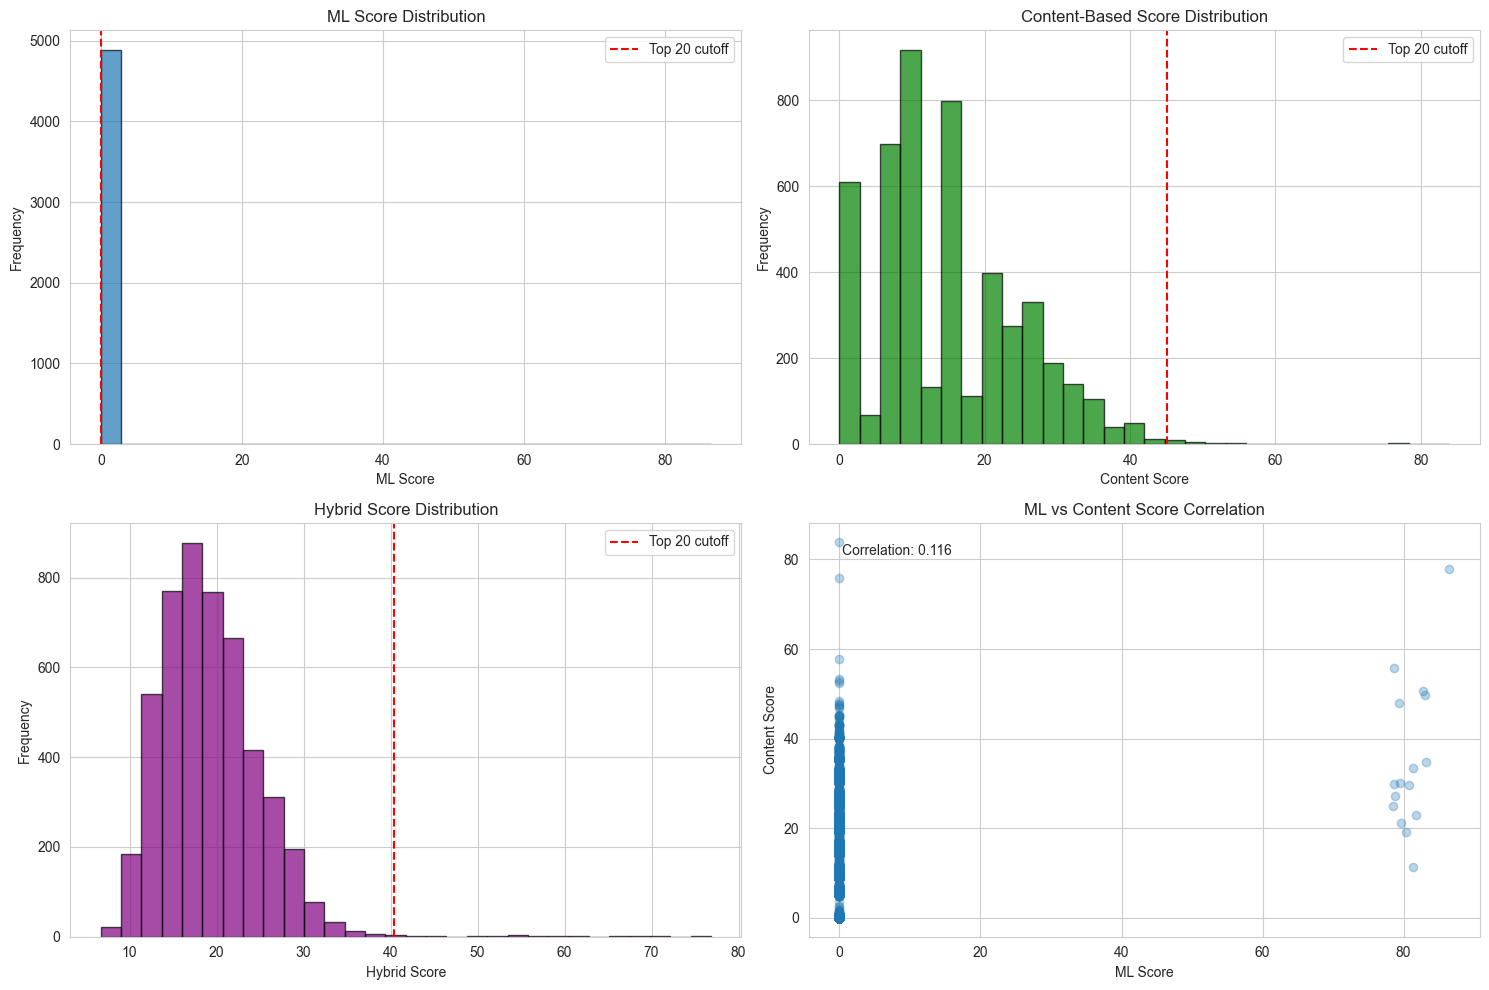


ML vs Content-Based correlation: 0.116
→ Low correlation: ML and Content capture DIFFERENT signals (good for hybrid!)


In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ML scores
axes[0, 0].hist(filtered_catalog['ml_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(top_20_ml['ml_score'].min(), color='red', linestyle='--', label='Top 20 cutoff')
axes[0, 0].set_xlabel('ML Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('ML Score Distribution')
axes[0, 0].legend()

# Content scores
axes[0, 1].hist(filtered_catalog['content_score'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(top_20_content['content_score'].min(), color='red', linestyle='--', label='Top 20 cutoff')
axes[0, 1].set_xlabel('Content Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Content-Based Score Distribution')
axes[0, 1].legend()

# Hybrid scores
axes[1, 0].hist(filtered_catalog['hybrid_score'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(top_20_hybrid['hybrid_score'].min(), color='red', linestyle='--', label='Top 20 cutoff')
axes[1, 0].set_xlabel('Hybrid Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Hybrid Score Distribution')
axes[1, 0].legend()

# Score correlation scatter
axes[1, 1].scatter(filtered_catalog['ml_score'], filtered_catalog['content_score'], alpha=0.3)
axes[1, 1].set_xlabel('ML Score')
axes[1, 1].set_ylabel('Content Score')
axes[1, 1].set_title('ML vs Content Score Correlation')
correlation = filtered_catalog[['ml_score', 'content_score']].corr().iloc[0, 1]
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
               transform=axes[1, 1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

print(f"\nML vs Content-Based correlation: {correlation:.3f}")
if correlation < 0.3:
    print("→ Low correlation: ML and Content capture DIFFERENT signals (good for hybrid!)")
elif correlation > 0.7:
    print("→ High correlation: ML and Content agree strongly (hybrid may not add much)")
else:
    print("→ Moderate correlation: ML and Content complement each other (hybrid promising!)")

## 11. Save Hybrid Recommendations

In [29]:
# Save top 20 for each approach
top_20_ml[['appid', 'name', 'ml_score', 'genre', 'positive', 'negative', 'median_forever', 'price']].to_csv(
    '../data/recommendations_ml_only.csv', index=False
)

top_20_content[['appid', 'name', 'content_score', 'genre', 'positive', 'negative', 'median_forever', 'price']].to_csv(
    '../data/recommendations_content_only.csv', index=False
)

top_20_preference[['appid', 'name', 'preference_score', 'genre', 'positive', 'negative', 'median_forever', 'price']].to_csv(
    '../data/recommendations_preference_only.csv', index=False
)

top_20_hybrid[['appid', 'name', 'hybrid_score', 'ml_score', 'content_score', 'preference_score', 'review_score', 
               'genre', 'positive', 'negative', 'median_forever', 'price']].to_csv(
    '../data/recommendations_hybrid.csv', index=False
)

print("✓ All recommendations saved!")
print("\nFiles created:")
print("  - recommendations_ml_only.csv (NO review bias)")
print("  - recommendations_content_only.csv (NO reviews in scoring)")
print("  - recommendations_preference_only.csv (disliked penalties)")
print("  - recommendations_hybrid.csv (35/35/20/10 proper weights)")

✓ All recommendations saved!

Files created:
  - recommendations_ml_only.csv (NO review bias)
  - recommendations_content_only.csv (NO reviews in scoring)
  - recommendations_preference_only.csv (disliked penalties)
  - recommendations_hybrid.csv (35/35/20/10 proper weights)


## Summary

### ✅ Hybrid System Complete with Proper Architecture!

**What We Built**:
1. Pure ML recommendations (learned from your playtime patterns, NO review bias)
2. Pure content-based recommendations (similarity to your loved games)
3. Pure preference recommendations (disliked penalties + optional boosts)
4. Hybrid recommendations (weighted combination of all 4 components)

**🎯 FIXED: Review Double-Counting Issue**:
- ❌ **Before**: Reviews counted twice (15% in content + 20% separate = 26% total)
- ✅ **After**: Reviews counted ONCE (0% in content, 10% separate)
- ✅ **ML Model**: Retrained WITHOUT review features (no review bias)
- ✅ **Content Score**: Only tags (55%) + genres (25%) + playtime (20%)
- ✅ **Preference Score**: Separated into own component (20%)
- ✅ **Review Score**: Standalone component (10%)

**Architecture (Correct Order)**:
```
Stage 1: Universal Filters (NSFW, Early Access, min reviews)
  ↓
Stage 2-5: Scoring (ML 35%, Content 35%, Prefs 20%, Review 10%)
  ↓
Stage 6: Hard Exclusions (user-specified never-show filters)
  ↓
Top 20 Recommendations
```

**Advanced Features Included**:

**🔒 Hard Filters** (auto-exclude before scoring):
- ✅ NSFW content filter (Sexual Content, Nudity, etc.)
- ✅ Early Access filter (exclude unfinished games)
- ✅ Meta genre filter (Utilities, Software, etc. excluded from matching)
- ✅ Meta tag filter (Indie, Casual, etc. excluded from matching)
- ✅ Minimum review count (1000+ reviews)
- ✅ Minimum review score (70%+ positive)
- ✅ Hard exclusions (user-specified genres/tags never shown) - applied LAST

**🎯 Component Scores** (4 separate, non-overlapping):
1. **ML Score (35%)**:
   - ✅ Learned from tags, genres, interaction features
   - ✅ NO review bias (reviews excluded from training)
   - ✅ Predicts engagement based on YOUR playtime patterns

2. **Content Score (35%)**:
   - ✅ Tag matching (55%) - weighted by YOUR playtime on each tag
   - ✅ Genre matching (25%) - broad category preferences
   - ✅ Median playtime (20%) - community engagement signal
   - ✅ NO reviews (moved to separate component)

3. **Preference Score (20%)**:
   - ✅ Disliked tag penalties (-5 points per tag from <5hr games)
   - ✅ Disliked genre penalties (-10 points per genre from <5hr games)
   - ✅ Optional user boosts (+5 to +20 points for preferred genres/tags)

4. **Review Score (10%)**:
   - ✅ Quality tiers (95%+ = 2.5x, <60% = 0.1x)
   - ✅ Volume bonus (logarithmic)
   - ✅ Counted ONCE (not in ML or Content)

**Key Improvements**:
- ✅ Each component counted exactly ONCE
- ✅ No double-counting of any signal
- ✅ Proper separation of concerns
- ✅ Interpretable weights (can tune each independently)
- ✅ Review bias eliminated from ML model

**Filtering Logic**:
```
1. Apply universal filters (NSFW, Early Access, min reviews, meta genres)
2. Calculate ML score (learned from playtime, NO reviews)
3. Calculate Content score (tags + genres + playtime, NO reviews)
4. Calculate Preference score (disliked penalties + optional boosts)
5. Calculate Review score (quality + volume)
6. Combine: 35% ML + 35% Content + 20% Prefs + 10% Reviews
7. Apply hard exclusions (user-specified never-show)
8. Return top 20
```

**Next Steps**:
1. ✅ Evaluate recommendations manually (which approach is best?)
2. Adjust hybrid weights based on your preferences (try weight experiments)
3. Set hard exclusions for genres/tags you never want to see
4. Set preference boosts for genres/tags you want to see more of
5. Add diversity filter to reduce similar games in top 20
6. Build web interface for easier interaction

**Files Created**:
- `recommendations_ml_only.csv` - Pure ML top 20 (NO review bias)
- `recommendations_content_only.csv` - Pure content-based top 20 (NO reviews)
- `recommendations_preference_only.csv` - Pure preference top 20
- `recommendations_hybrid.csv` - Hybrid top 20 (all 4 components)

**How This Differs from Broken Version**:
- ✅ Reviews counted ONCE (10%) instead of twice (26%)
- ✅ ML trained WITHOUT review features
- ✅ Content score excludes reviews
- ✅ Preference score is separate component (20%)
- ✅ Proper 35/35/20/10 weights (not 40/40/20)
- ✅ Each component is independent and tunable

## 13. Experiment: Tune Hybrid Weights

Try different weight combinations to see which works best

In [30]:
# Define weight combinations to try
weight_experiments = [
    {'name': 'ML Heavy', 'ml': 0.45, 'content': 0.25, 'pref': 0.20, 'review': 0.10},
    {'name': 'Content Heavy', 'ml': 0.25, 'content': 0.45, 'pref': 0.20, 'review': 0.10},
    {'name': 'Balanced (Default)', 'ml': 0.35, 'content': 0.35, 'pref': 0.20, 'review': 0.10},
    {'name': 'Preference Heavy', 'ml': 0.30, 'content': 0.30, 'pref': 0.30, 'review': 0.10},
]

print("WEIGHT TUNING EXPERIMENTS")
print("="*80)

for exp in weight_experiments:
    # Calculate hybrid score with these weights on filtered catalog
    col_name = f'hybrid_{exp["name"].lower().replace(" ", "_").replace("(", "").replace(")", "")}'
    filtered_catalog[col_name] = (
        exp['ml'] * filtered_catalog['ml_score'] +
        exp['content'] * filtered_catalog['content_score'] +
        exp['pref'] * filtered_catalog['preference_score'] +
        exp['review'] * filtered_catalog['review_score']
    )
    
    # Get top 10 for this configuration
    top_10 = filtered_catalog.nlargest(10, col_name)
    
    print(f"\n{exp['name']} (ML: {exp['ml']:.0%}, Content: {exp['content']:.0%}, Prefs: {exp['pref']:.0%}, Review: {exp['review']:.0%})")
    print("-" * 80)
    for idx, (_, row) in enumerate(top_10.iterrows(), 1):
        print(f"{idx}. {row['name']} (Score: {row[col_name]:.1f})")

print("\n" + "="*80)
print("Compare the lists above and see which weight combination appeals most to you!")

WEIGHT TUNING EXPERIMENTS

ML Heavy (ML: 45%, Content: 25%, Prefs: 20%, Review: 10%)
--------------------------------------------------------------------------------
1. Grand Theft Auto V Legacy (Score: 77.7)
2. Terraria (Score: 73.3)
3. Black Myth: Wukong (Score: 70.8)
4. The Elder Scrolls V: Skyrim (Score: 70.2)
5. Kingdom Come: Deliverance II (Score: 69.3)
6. DARK SOULS III (Score: 67.6)
7. Hollow Knight (Score: 64.7)
8. METAL GEAR SOLID V: THE PHANTOM PAIN (Score: 64.6)
9. Rise of the Tomb Raider (Score: 62.1)
10. Tomb Raider Game of the Year (Score: 61.5)

Content Heavy (ML: 25%, Content: 45%, Prefs: 20%, Review: 10%)
--------------------------------------------------------------------------------
1. Grand Theft Auto V Legacy (Score: 76.0)
2. Terraria (Score: 68.8)
3. Black Myth: Wukong (Score: 64.2)
4. The Elder Scrolls V: Skyrim (Score: 63.8)
5. Kingdom Come: Deliverance II (Score: 63.0)
6. DARK SOULS III (Score: 57.9)
7. METAL GEAR SOLID V: THE PHANTOM PAIN (Score: 55.1)
8. Hol

## Summary

### ✅ Hybrid System Complete!

**What We Built**:
1. Pure ML recommendations (learned from your playtime patterns)
2. Pure content-based recommendations (similarity to your loved games)
3. Hybrid recommendations (weighted combination)

**Key Findings**:
- ML vs Content correlation: [see output above]
- Overlap between approaches: [see output above]
- Best weight configuration: **To be determined based on your evaluation**

**Next Steps**:
1. ✅ Evaluate recommendations manually (which approach is best?)
2. Adjust hybrid weights based on your preferences
3. Add diversity filter to reduce similar games in top 20
4. Implement user preference system (boost/penalize tags/genres)
5. Build web interface for easier interaction

**Files Created**:
- `recommendations_ml_only.csv` - Pure ML top 20
- `recommendations_content_only.csv` - Pure content-based top 20
- `recommendations_hybrid.csv` - Hybrid top 20